# deepSSAM prototype notebook

This notebook contains a prototype implementation of a deepSSAM neural network algorithm that uses a pre-trained neural network to generalize gene expression information to FITC/DAPI technology information.

#### Imports:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata


#### Parameter definition:

In [3]:
img_path_wall = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_Cellbound3_z4.tif'
img_path_dapi = '../../vizgen-merfish/vz-liver-showcase/Liver1Slice1/images/mosaic_DAPI_z4.tif'
coordinate_path = '../../../../raw_data/vizgen-merfish/vz-liver-showcase/Liver1Slice1/detected_transcripts.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [4]:
# SSAM vector field resolution:
um_per_pixel = 2.5

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


In [5]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

df.columns=['x','y','z','gene']

df = df[~df.gene.str.contains('Blank')]

df.x-=df.x.min()
df.y-=df.y.min()
df.x/=um_per_pixel/scale
df.y/=um_per_pixel/scale

df.gene = df.gene.astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index

In [ ]:
# heg = df.gene.value_counts().index[:40]

marker_list = pd.read_csv('/dh-projects/ag-ishaque/analysis/tiesmeys/data/z-incoherence/mouse_liver_markers_10.1038_s41421-021-00266-1_NI_v1.tsv',sep='\t',header=0)

signature_matrix = pd.DataFrame(np.eye(len(genes)),index=genes,columns=genes)
# marker_list = marker_list.rename(columns = {'#gene':'gene'})

# marker_list = marker_list[marker_list.gene.isin(gene_counts.index)]
# marker_genes = marker_list.gene.unique()

# celltypes = marker_list.celltype.unique()

# signatures = pd.DataFrame(np.zeros((len(genes),len(celltypes))),index=genes,columns=celltypes)

# for celltype in celltypes:
#     celltype_specific_genes = marker_list[marker_list.celltype==celltype].gene.values
#     signatures.loc[celltype_specific_genes,celltype]=1



# # signatures = pd.DataFrame(np.zeros((len(marker_genes),len(celltypes))),index=marker_genes,columns=celltypes)

# # for celltype in celltypes:
# #     celltype_specific_genes = marker_list[marker_list.celltype==celltype].gene.values
# #     signatures.loc[celltype_specific_genes,celltype]=1

# # df = df[df.gene.isin(marker_genes)].copy()
# # df['gene'] = df.gene.cat.remove_unused_categories()


# # gene_counts = df.gene.value_counts()
# # genes = gene_counts.index

In [ ]:
celltypes

array(['AEC', 'Basophil', 'EC', 'Erythroid_cell', 'Erythroid_progenitor',
       'Hepatocyte', 'HSC', 'Macrophage', 'MK', 'Myeloid', 'Neutrophil',
       'Pre-B_cell', 'SEC'], dtype=object)

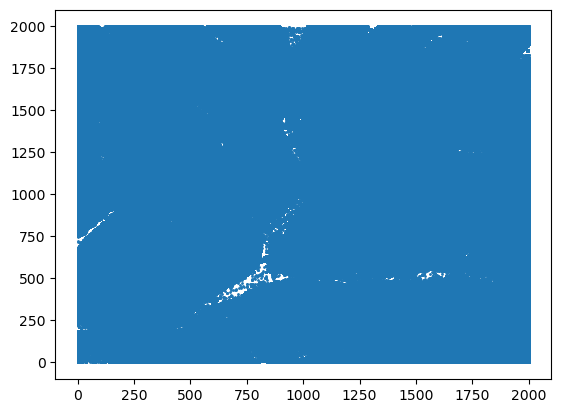

In [ ]:
#

x_lims = [1000,3000]
y_lims = [1000,3000]

df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])

df = df[df_mask]

df.x-=df.x.min()
df.y-=df.y.min()

plt.scatter(df.x,df.y,s=1)


#### Determine overlap-ROIs:

In [ ]:
from src import ovrlp

KDE_bandwidth=1.0
threshold_fraction=0.5
min_distance=10
density_weight=2

ovrlp.assign_xy(df)
ovrlp.assign_z_mean(df)

divergence_map, signal_histogram = ovrlp.compute_divergence_map(df,genes,1,0.5)

distance_score = divergence_map*signal_histogram**density_weight
distance_threshold = distance_score.max()*threshold_fraction

rois_x, rois_y, distance_score = ovrlp.determine_localmax(distance_score, min_distance, distance_threshold)

roi_df = pd.DataFrame({'x':rois_x, 'y':rois_y, 'divergence':distance_score})
roi_df = roi_df.sort_values('divergence', ascending=False)

#### SSAM-pre-calculations

In [ ]:
from sklearn.decomposition import PCA as dim_reduction
import umap

# Find expression signal peaks:
rois_celltyping_x,rois_celltyping_y = ovrlp.get_rois(df, genes = genes, min_distance=5,
                        KDE_bandwidth=1.5, min_expression=10,)

# extract expression vectors at local maxima:
localmax_celltyping_samples =  ovrlp.get_expression_vectors_at_rois(df,rois_celltyping_x,rois_celltyping_y,genes,) 

# normalize expression vectors:
localmax_celltyping_samples = localmax_celltyping_samples/(localmax_celltyping_samples.to_numpy()**2).sum(0,keepdims=True)**0.5

# dimensionality reduction on expression vectors:
dr = dim_reduction(n_components=min(100,localmax_celltyping_samples.shape[0]//2))
factors = dr.fit_transform(localmax_celltyping_samples.T)

# Perform 2d UMAP embedding for scatter plot visualization:
embedder_2d = umap.UMAP(n_components=2,min_dist=0.0)
embedding = embedder_2d.fit_transform(factors)

# Perform 3d UMAP embedding for color visualization:
embedder_3d = umap.UMAP(n_components=3, min_dist=0.0,n_neighbors=10,
                init=np.concatenate([embedding,0.1*np.random.normal(size=(embedding.shape[0],1))],axis=1))
embedding_color = embedder_3d.fit_transform(embedding)
embedding_color,color_pca = ovrlp.fill_color_axes(embedding_color)
color_min = embedding_color.min(0)
color_max = embedding_color.max(0)

colors = ovrlp.min_to_max(embedding_color.copy())

celltypes = sorted(signature_matrix.columns)

# gene_intersection = list(set(signature_matrix.index).intersection(set(genes)))
celltype_class_assignments = ovrlp.determine_celltype_class_assignments(localmax_celltyping_samples,signature_matrix)
# print(celltype_class_assignments)
# determine the center of gravity of each celltype in the embedding:
celltype_centers = np.array([np.median(embedding[celltype_class_assignments==i,:],axis=0) for i in range(len(celltypes))])





In [ ]:
subsample_mask.mean()

0.0

In [ ]:
import random
random.seed(42)

n_cases = [10]

plot_window_size = 30

for n_case in n_cases:
    x,y = roi_df.x.iloc[n_case],roi_df.y.iloc[n_case]

    # ct_top,ct_bottom = get_celltype(expressions_top.iloc[idcs[n_case]]),get_celltype(expressions_bottom.iloc[idcs[n_case]])

    print("Plotting case {}".format(n_case))

    subsample_mask = ovrlp.get_spatial_subsample_mask(df,x,y,plot_window_size=plot_window_size)
    subsample = df[subsample_mask]

    distances, neighbor_indices = ovrlp.create_knn_graph(subsample[['x','y','z']].values,k=90)
    local_expression = ovrlp.get_knn_expression(distances,neighbor_indices,genes,subsample.gene.cat.codes.values,bandwidth=2.5)
    local_expression = local_expression/((local_expression**2).sum(0)**0.5)
    subsample_embedding, subsample_embedding_color = ovrlp.transform_embeddings(local_expression.T.values,dr,embedder_2d=embedder_2d,embedder_3d=embedder_3d)
    subsample_embedding_color,_ = ovrlp.fill_color_axes(subsample_embedding_color,color_pca)
    subsample_embedding_color = (subsample_embedding_color-color_min)/(color_max-color_min)
    subsample_embedding_color = np.clip(subsample_embedding_color,0,1)

    plt.figure(figsize=(18,12))

    ax1 = plt.subplot(234,projection='3d')
    ax1.scatter(subsample.x,subsample.y,subsample.z,c=subsample_embedding_color,marker='.',alpha=0.1)
    ax1.set_zlim(np.median(subsample.z)-plot_window_size,np.median(subsample.z)+plot_window_size)

    ax2 = plt.subplot(231)
    plt.scatter(embedding[:,0],embedding[:,1],c='lightgrey',alpha=0.05,marker='.',s=1)
    ovrlp.plot_embeddings(subsample_embedding,subsample_embedding_color,celltype_centers,celltypes)
    
    ax3 = plt.subplot(235)
    # plt.imshow((divergence*hist_sum).T,cmap='Greys', alpha=0.3 )
    ax3.scatter(subsample[subsample.z>subsample.z_delim].x,subsample[subsample.z>subsample.z_delim].y,
    c=subsample_embedding_color[subsample.z>subsample.z_delim],marker='.',alpha=0.1,s=50)
    ax3.set_xlim(x-plot_window_size,x+plot_window_size)
    ax3.set_ylim(y-plot_window_size,y+plot_window_size)
    ax3.scatter(x,y,c='k',marker='+',s=100)
    plt.title("celltypes (top)")

    ax3 = plt.subplot(236)    
    # plt.imshow(hist_sum.T,cmap='Greys',alpha=0.3 )
    ax3.scatter(subsample[subsample.z<subsample.z_delim].x,subsample[subsample.z<subsample.z_delim].y,
    c=subsample_embedding_color[subsample.z<subsample.z_delim],marker='.',alpha=0.1,s=50)
    ax3.set_xlim(x-plot_window_size,x+plot_window_size)
    ax3.set_ylim(y-plot_window_size,y+plot_window_size)
    plt.title("celltypes (bottom)")

    ax4 = plt.subplot(232)
    plt.scatter(df.x,df.y,c='lightgrey',alpha=0.01,marker='.',s=1)
    plt.scatter(subsample.x,subsample.y,c=subsample_embedding_color,marker='.',alpha=0.8,s=1)
    plt.scatter(roi_df.x,roi_df.y,c=roi_df.divergence,marker='+',s=100,cmap='autumn')
    ax3.scatter(x,y,c='k',marker='+',s=100)

: 

In [ ]:
assert False

/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Plotting case 0


/tmp/ipykernel_2804075/1014868378.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,2)


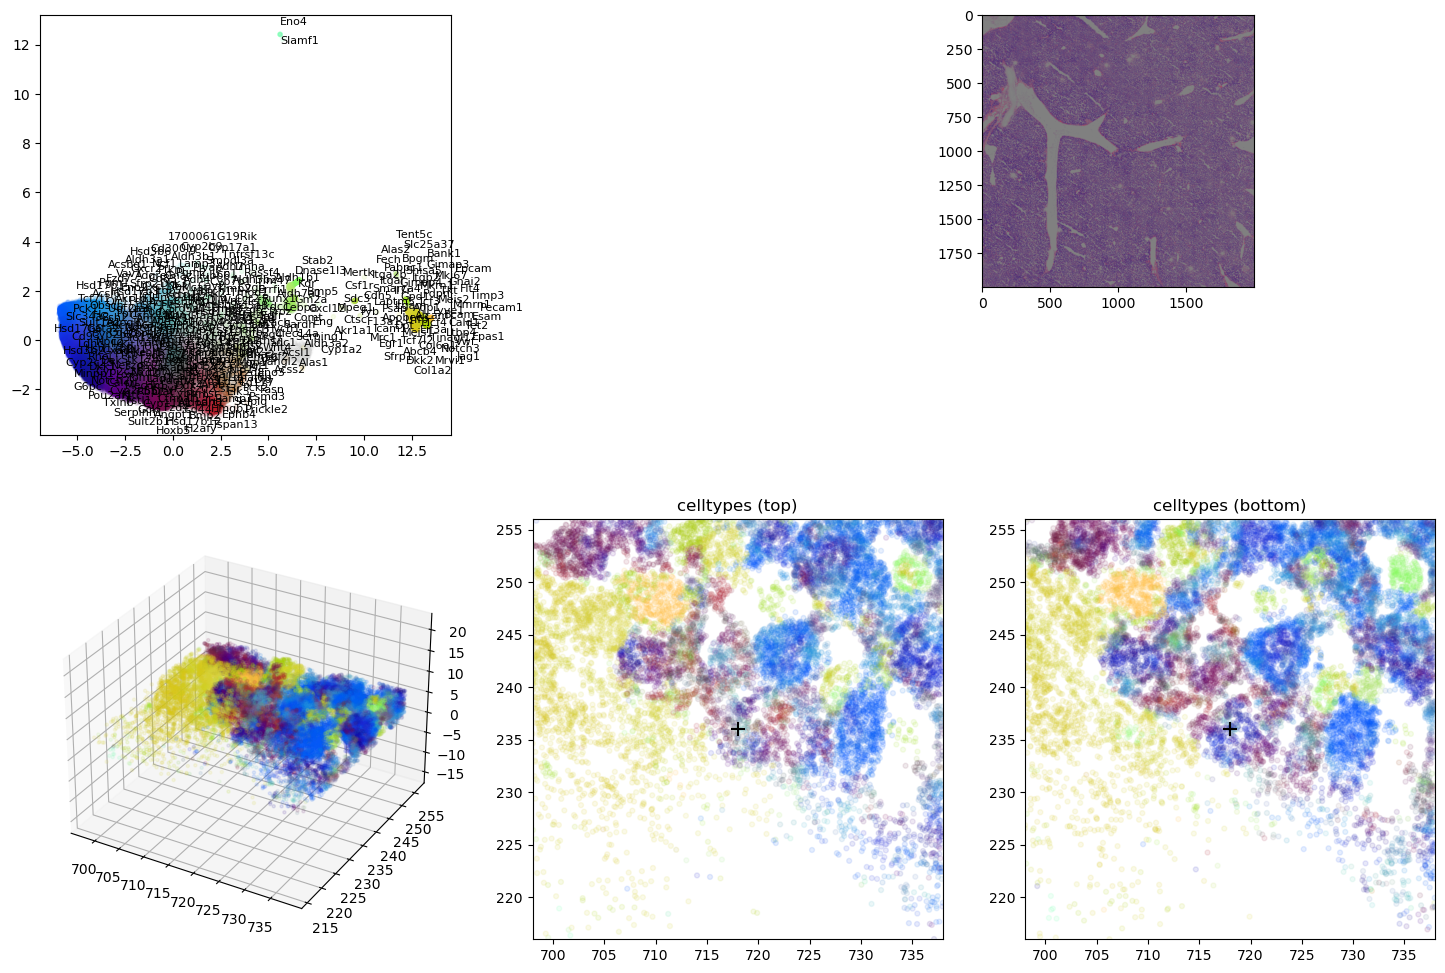

In [ ]:
import random

random.seed(42)

ovrlp.visualize_rois(df,roi_df, signature_matrix = None,
                     celltyping_min_expression=2,
                     n_cases=range(1),plot_window_size=20)


plt.subplot(2,3,2)
# f, (p, b1,b2) = plt.subplots(1, 3, width_ratios=[7, 1,1],figsize=(15,9))
from matplotlib.colors import LinearSegmentedColormap

BlGr = LinearSegmentedColormap.from_list('BlGr', ['grey','navy'], N=256)
TrRd = LinearSegmentedColormap.from_list('TrRd', [[1.0,0.4,0.4,0.0],[1.0,0.0,0.0,1.0]], N=256)

handle_hist_sum = plt.imshow(signal_histogram,cmap=BlGr,alpha=1)

incoherence = divergence_map*signal_histogram
incoherence/=incoherence.max()

handle_divergence = plt.imshow(incoherence,cmap=TrRd)

# plt.colorbar(handle_hist_sum,cax=b1)
# plt.colorbar(handle_divergence,cax=b2)

# b1.set_title('signal')
# b2.set_title('incoherence')

In [ ]:
print(str(list(genes)[::3]).replace("'",'').replace(' ',''))

[Fasn,Serping1,Errfi1,Aldh7a1,Proz,Cyp2b9,Epas1,Acss2,Hsd17b6,Cxcl12,Gm2a,Gck,Hsd17b2,Tkt,Hsd17b12,Tmem56,Ugt2b1,Ctsc,Acsl5,Hsd17b7,Pgam1,Fgf1,Aqp1,Nrp1,Minpp1,Smarca4,Dld,Dek,Mpp1,Cxadr,Ltbp4,Sgms2,Smpdl3a,Tet2,Oxsm,Kctd12,Unc93b1,Arsb,Eif3f,Pdhb,Timp3,Col1a2,Bpgm,Cd300lg,Hsd3b2,Tubb6,Esam,Hgf,Bmp5,Ssh2,Gimap6,Dll4,Tek,Icam1,Stk17b,Hmgb1,Tfrc,Vcam1,Jag1,G6pc3,Apobec3,Dkk1,Pgm2,Itgb2,Cd93,Rassf4,Satb1,Ace,Cyp2c55,Ldhc,Bcam,Fzd1,Ctnnal1,Ramp1,Procr,Pfkp,Hk3,Tgfb2,Trim47,Lck,Dkk3,Kitl,Cav2,Vav1,Cdh11,Cyp11b1,Gata2,Acsbg2,Aldoart1,Hsd11b2,Wnt4,Notch4,Cd44,Notch3,Cyp2b23,Fzd2,Cd177,Dkk2,Cxcl14,Akap14,Pdpn,Ccr1,Acsbg1,Ms4a1,Pgam2,1700061G19Rik,Klrb1c,Aldh3b2,Aldh3a1,Ldhal6b,F13a1,Cxcr2,Flt3,Ryr2,Tnfrsf13c,Hsd3b6]


In [ ]:
import os
import h5py as h5

os.listdir('../../data/vizgen-merfish/vz-liver-showcase/Liver1Slice2/')

cell_metadata = pd.read_csv('../../data/vizgen-merfish/vz-liver-showcase/Liver1Slice2/cell_metadata.csv', sep=',', header=0)

cell_metadata.head()
# f = h5.File('../../data/vizgen-merfish/vz-liver-showcase/Liver1Slice2/cell_boundaries/feature_data_563.hdf5', 'r')


# coords = np.array(f['featuredata']['102393346795905022879352815478289066900']['zIndex_6']['p_0']['coordinates'])

# f['featuredata'].keys()
# plt.plot(*coords[0,:].T)


FileNotFoundError: [Errno 2] No such file or directory: '../../data/vizgen-merfish/vz-liver-showcase/Liver1Slice2/'

In [ ]:
df

x          y    z     gene
123699488   21.47404   23.79768  0.0     Comt
123699490   30.30020   28.04464  0.0     Comt
123699491   39.17960   30.95048  0.0     Comt
123699494   21.59772   38.29744  0.0     Comt
123699496    4.79876   42.95368  0.0     Comt
...              ...        ...  ...      ...
252817925  943.48692  964.64488  4.0  Hsd17b3
252817927  983.73772  999.29796  4.0  Hsd17b3
252817928  944.03492  959.63328  5.0  Hsd17b3
252817929  944.70212  980.58528  5.0  Hsd17b3
252817930  997.97132  983.61808  6.0  Hsd17b3

[34023079 rows x 4 columns]

#### Perform analysis step-by-step to capture Naveed's incoherence map:

In [ ]:

from src import ovrlp


ovrlp.assign_xy(df)
ovrlp.assign_z_mean(df)


rois_x, rois_y, divergence, hist_sum, divergence_map = ovrlp.compute_divergence(df, genes, plot=False,return_maps=True)



In [ ]:
from matplotlib.colors import LinearSegmentedColormap

BlGr = LinearSegmentedColormap.from_list('BlGr', ['grey','navy'], N=256)
TrRd = LinearSegmentedColormap.from_list('TrRd', [[1.0,0.4,0.4,0.0],[1.0,0.0,0.0,1.0]], N=256)

Text(0.5, 1.0, 'incoherence')

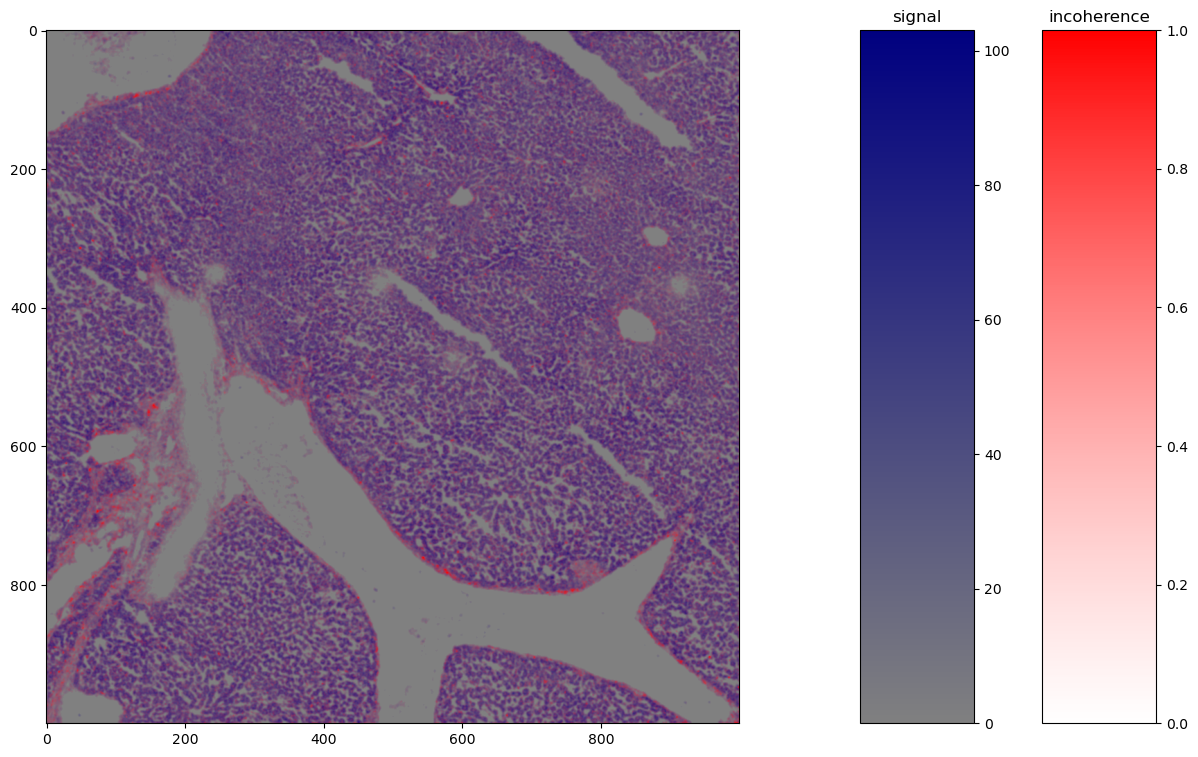

In [ ]:
f, (p, b1,b2) = plt.subplots(1, 3, width_ratios=[7, 1,1],figsize=(15,9))

handle_hist_sum = p.imshow(hist_sum,cmap=BlGr,alpha=1)

incoherence = divergence_map*hist_sum
incoherence/=incoherence.max()

handle_divergence = p.imshow(incoherence,cmap=TrRd)

plt.colorbar(handle_hist_sum,cax=b1)
plt.colorbar(handle_divergence,cax=b2)

b1.set_title('signal')
b2.set_title('incoherence')

In [ ]:
path_scrnaseq = "/dh-projects/ag-ishaque/raw_data/tiesmeys-scRNAseq/mouse-liver"

metadata = pd.read_csv(os.path.join("/",*path_scrnaseq.split('/'),'GSE166504_cell_metadata.20220204.tsv'),sep='\t',header=0)
raw_counts = pd.read_csv(os.path.join("/",*path_scrnaseq.split('/'),'GSE166504_cell_raw_counts.20220204.txt'),sep='\t',header=0)

raw_counts

NPC_15weeks_Animal1_Capture2_AAACCTGAGACAAAGG  \
Kitl                                                   0   
Gm4301                                                 0   
Gm4312                                                 0   
Gm4303                                                 0   
Gm4305                                                 0   
...                                                  ...   
Gm20854                                                0   
Gm20854.1                                              0   
Gm20815                                                0   
Kdm5d                                                  0   
Erdr1                                                  0   

           NPC_15weeks_Animal1_Capture2_AAACCTGCACCCATTC  \
Kitl                                                   0   
Gm4301                                                 0   
Gm4312                                                 0   
Gm4303                                                 0   
Gm4305                                                 0   
...                                                  ...   
Gm20854                                                0   
Gm20854.1                                              0   
Gm20815                                                0   
Kdm5d                                                  0   
Erdr1                                                  0   

           NPC_15weeks_Animal1_Capture2_AAACCTGCATGCTAGT  \
Kitl                                                   0   
Gm4301                                                 0   
Gm4312                                                 0   
Gm4303                                                 0   
Gm4305                                                 0   
...                                                  ...   
Gm20854                                                0   
Gm20854.1                                              0   
Gm20815                                                0   
Kdm5d                                                  0   
Erdr1                                                  0   

           NPC_15weeks_Animal1_Capture2_AAACCTGGTTCGCGAC  \
Kitl                                                   0   
Gm4301                                                 0   
Gm4312                                                 0   
Gm4303                                                 0   
Gm4305                                                 0   
...                                                  ...   
Gm20854                                                0   
Gm20854.1                                              0   
Gm20815                                                0   
Kdm5d                                                  0   
Erdr1                                                  0   

           NPC_15weeks_Animal1_Capture2_AAACCTGTCTGCCAGG  \
Kitl                                                   0   
Gm4301                                                 0   
Gm4312                                                 0   
Gm4303                                                 0   
Gm4305                                                 0   
...                                                  ...   
Gm20854                                                0   
Gm20854.1                                              0   
Gm20815                                                0   
Kdm5d                                                  0   
Erdr1                                                  0   

           NPC_15weeks_Animal1_Capture2_AAACGGGAGGAATTAC  \
Kitl                                                   0   
Gm4301                                                 0   
Gm4312                                                 0   
Gm4303                                                 0   
Gm4305                                                 0   
...                                           

In [ ]:

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

df.columns=['x','y','z','gene']

df = df[~df.gene.str.contains('Blank')]
df = df[df.gene.isin(raw_counts.index)].copy()

df.x-=df.x.min()
df.y-=df.y.min()
df.x/=um_per_pixel/scale
df.y/=um_per_pixel/scale

df.gene = df.gene.astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index



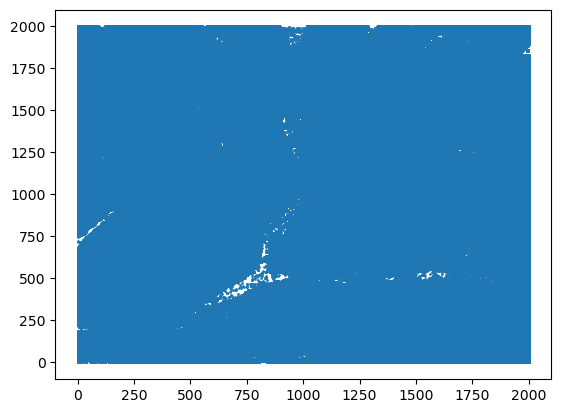

In [ ]:

x_lims = [1000,3000]
y_lims = [1000,3000]

df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])

df = df[df_mask]

df.x-=df.x.min()
df.y-=df.y.min()

plt.scatter(df.x,df.y,s=1)


In [ ]:
raw_counts = raw_counts[raw_counts.index.isin(genes)]

celltypes = metadata.CellType.unique()

signatures = pd.DataFrame(np.zeros((len(genes),len(celltypes))),index=genes,columns=celltypes)

for i,celltype in enumerate(celltypes):
    cells_with_celltype = metadata[metadata.CellType==celltype]
    cells_with_celltype_ids = cells_with_celltype[['FileName','CellID']].agg('_'.join,axis=1)
    
    signatures[celltype] = raw_counts[cells_with_celltype_ids].mean(axis=1)
# signatures[:] = np.log(signatures+1)

signatures/=(signatures.sum()+1)

In [ ]:
from src import ovrlp

roi_df = ovrlp.find_overlaps(df,min_distance=10)

roi_df

x     y    divergence
208  1477   320  11195.566091
248  1808   267  10840.756435
222  1591   189  10577.609512
238  1718  1236  10289.389665
178  1173   282   9449.509291
..    ...   ...           ...
110   870   873   5612.277659
184  1256  1565   5606.258888
229  1632  1258   5602.185486
134   944  1218   5600.984153
263  1930  1873   5600.929082

[270 rows x 3 columns]

Plotting case 0
Plotting case 1
Plotting case 2
Plotting case 3
Plotting case 4


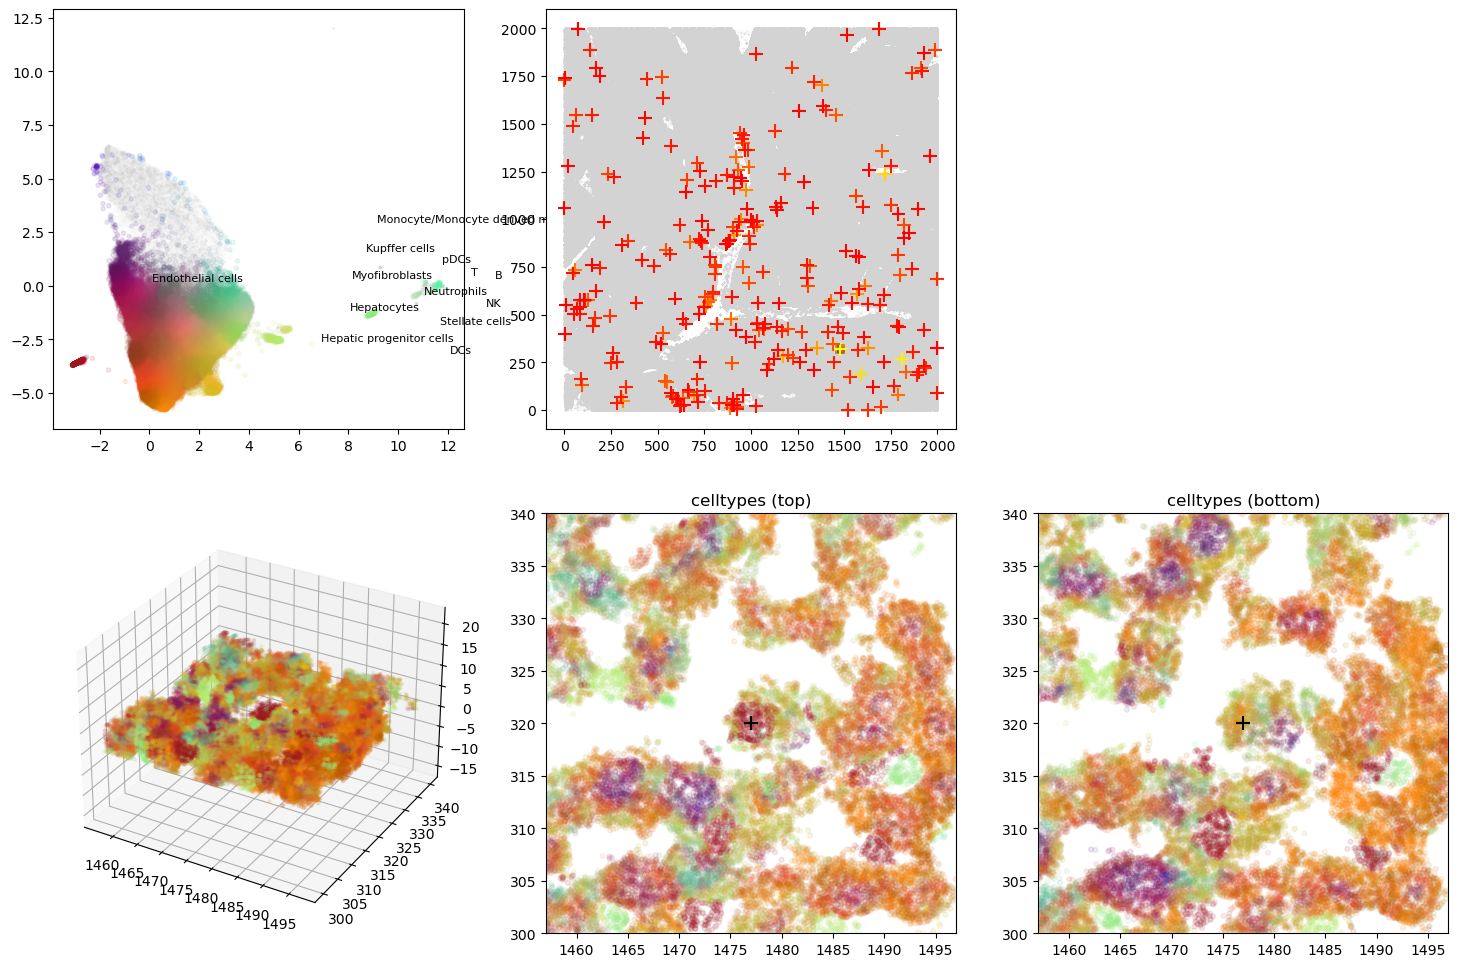

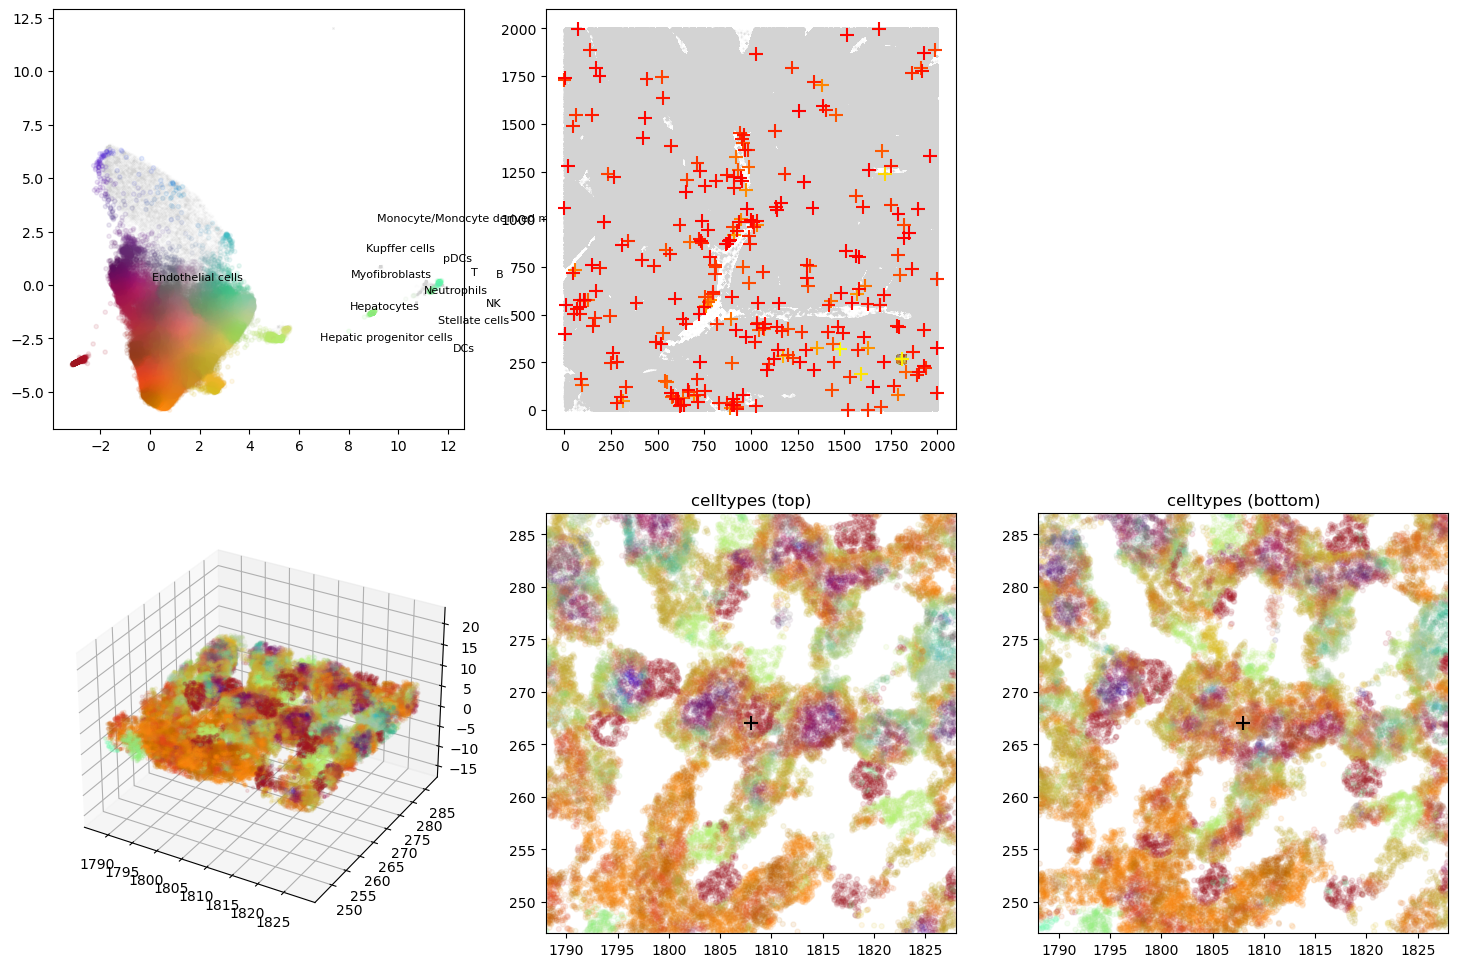

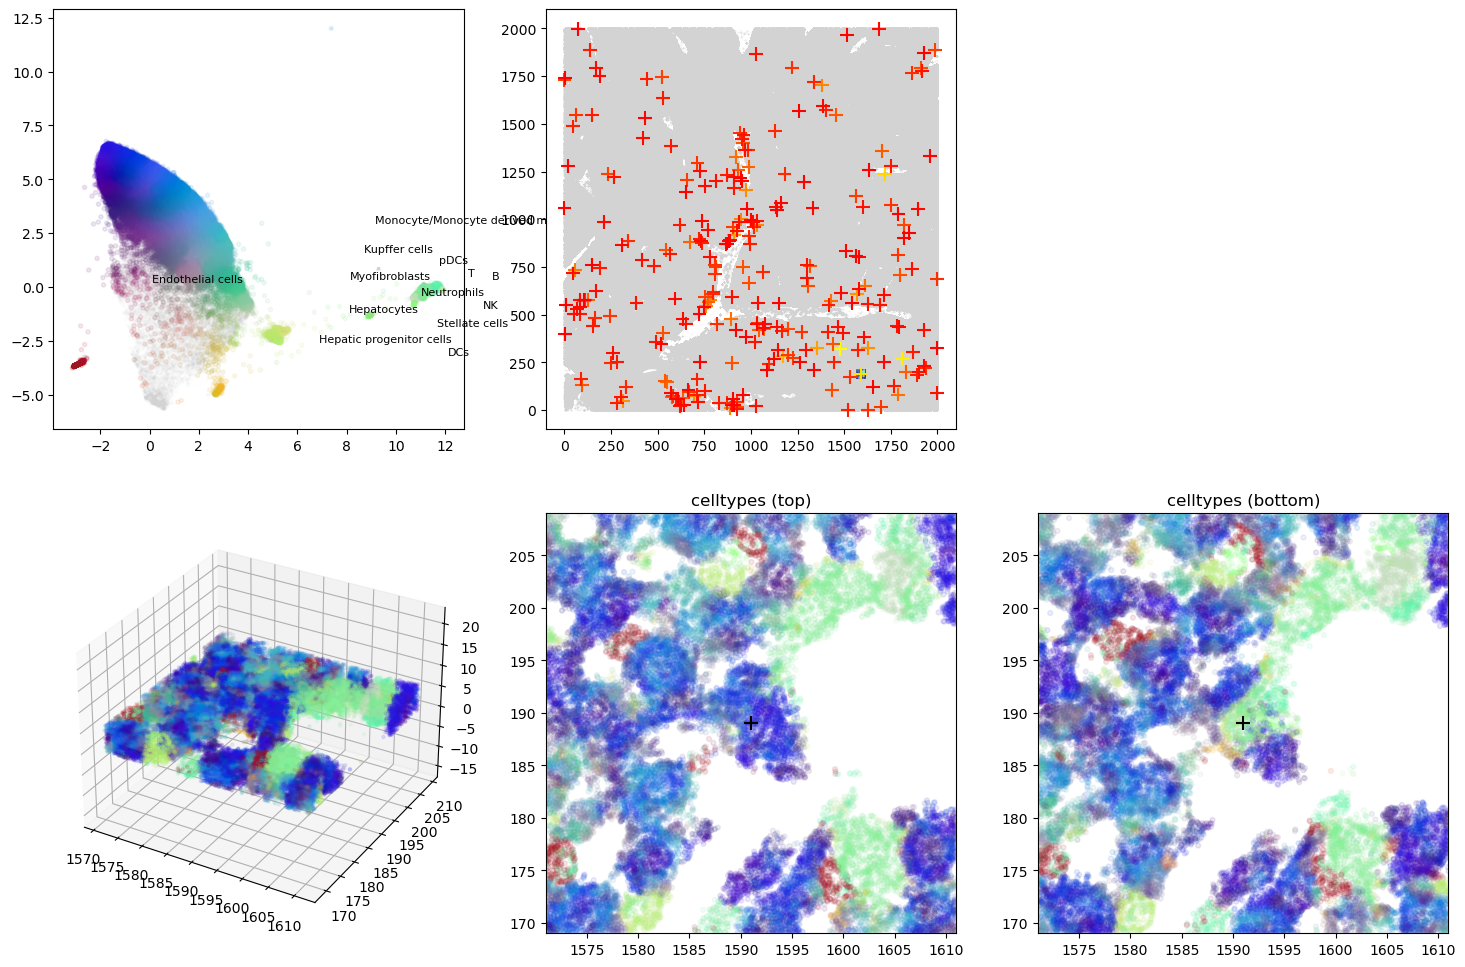

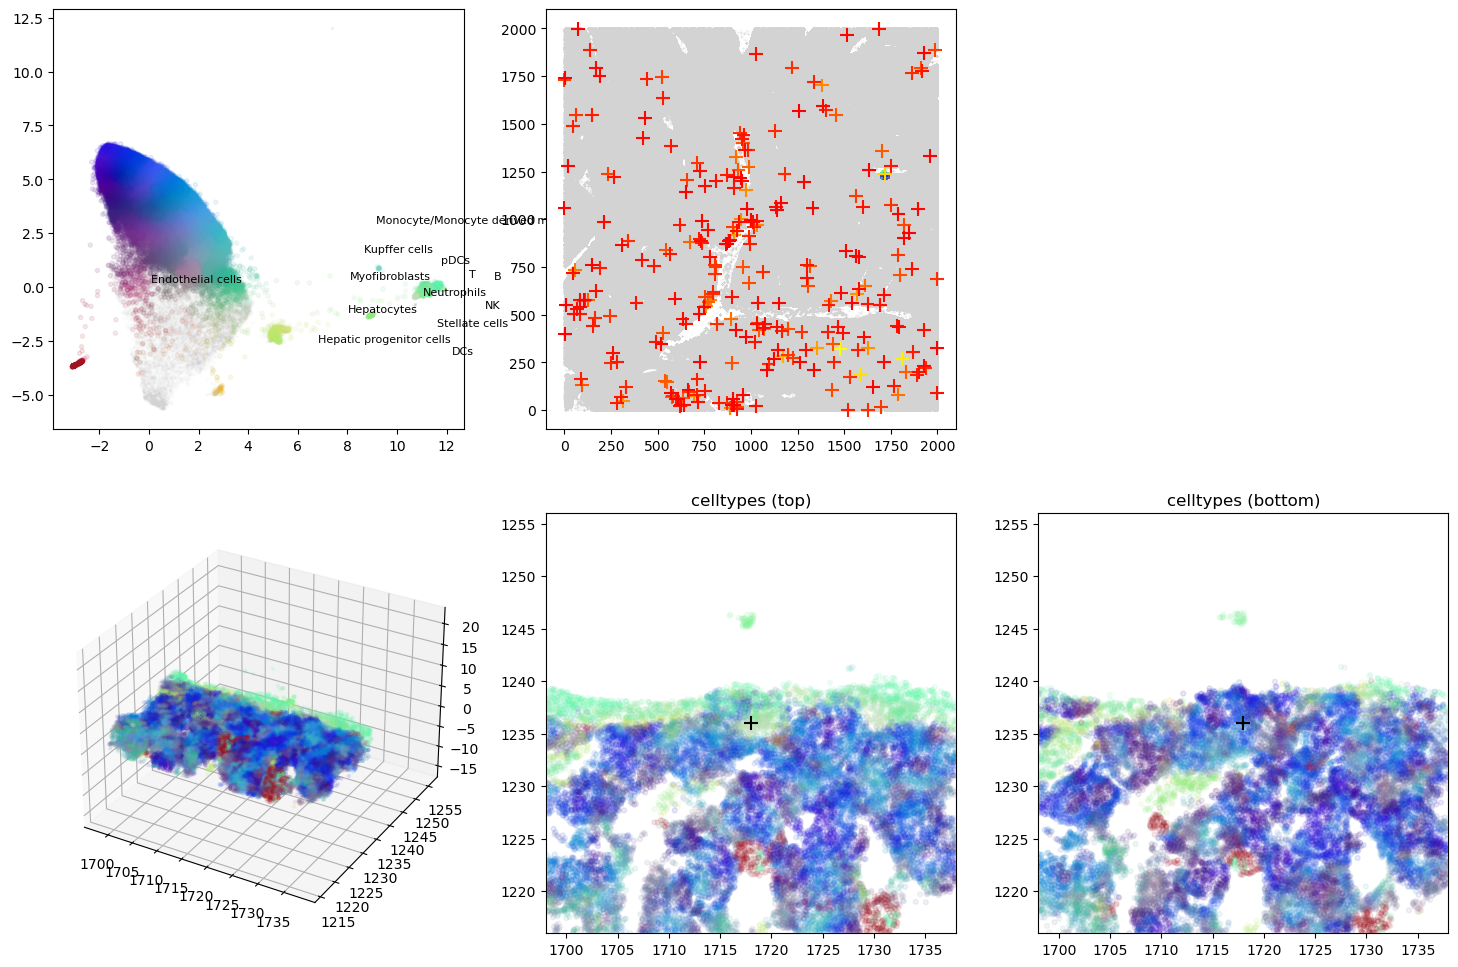

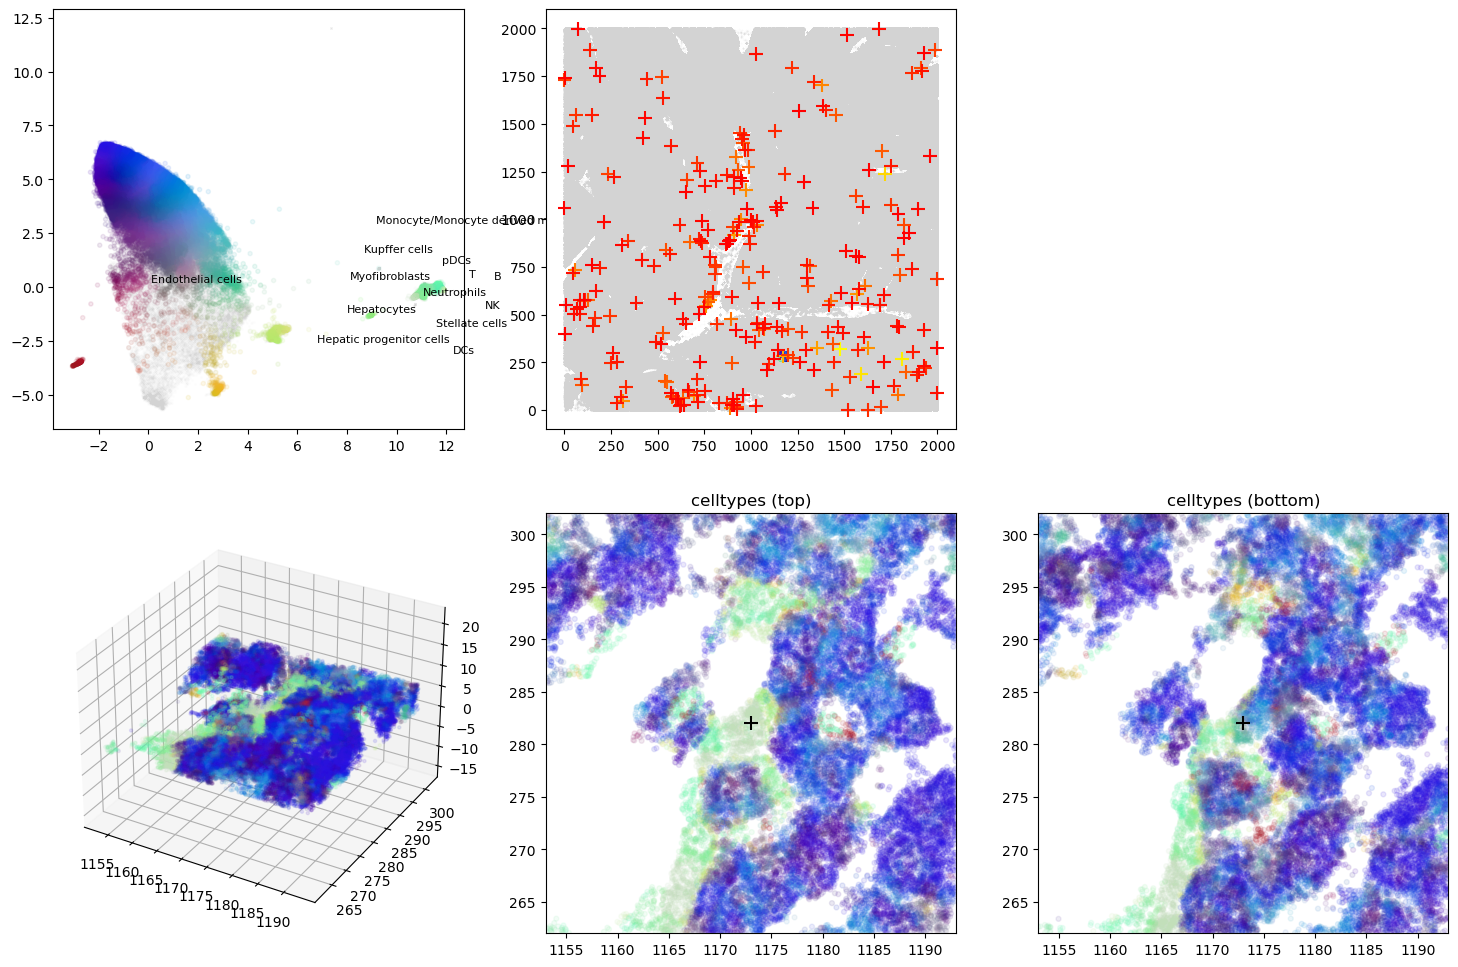

In [ ]:
import random

random.seed(42)

ovrlp.visualize_rois(df,roi_df, signature_matrix = signatures,
                     celltyping_min_expression=2,
                     n_cases=range(1),plot_window_size=20)

In [ ]:
path_scrnaseq = "/dh-projects/ag-ishaque/raw_data/tiesmeys-scRNAseq/mouse-liver-atlas"

metadata = pd.read_csv(os.path.join("/",*path_scrnaseq.split('/'),'annot_mouseStStAll.csv'),sep=',',header=0)
# raw_counts = pd.read_csv(os.path.join("/",*path_scrnaseq.split('/'),'GSE166504_cell_raw_counts.20220204.txt'),sep='\t',header=0)

metadata.annot.unique()

array(['T cells', 'ILC1s', 'NK cells', 'B cells', 'pDCs', 'Kupffer cells',
       'Monocytes & Monocyte-derived cells', 'cDC2s', 'Mig. cDCs',
       'cDC1s', 'Neutrophils', 'Endothelial cells', 'Hepatocytes',
       'Cholangiocytes', 'Fibroblasts', 'Basophils', 'HsPCs'],
      dtype=object)